# GLOVE Word Embeddings with NLU 

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.     

### Sources :
- https://nlp.stanford.edu/pubs/glove.pdf

### Paper abstract :

Recent methods for learning vector space
representations of words have succeeded
in capturing fine-grained semantic and
syntactic regularities using vector arithmetic, but the origin of these regularities
has remained opaque. We analyze and
make explicit the model properties needed
for such regularities to emerge in word
vectors. The result is a new global logbilinear regression model that combines
the advantages of the two major model
families in the literature: global matrix
factorization and local context window
methods. Our model efficiently leverages
statistical information by training only on
the nonzero elements in a word-word cooccurrence matrix, rather than on the entire sparse matrix or on individual context
windows in a large corpus. The model produces a vector space with meaningful substructure, as evidenced by its performance
of 75% on a recent word analogy task. It
also outperforms related models on similarity tasks and named entity recognition.


# 1. Install Java and NLU

In [1]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    


## 2. Load Model and embed sample string with GLOVE

In [2]:
import nlu
pipe = nlu.load('glove')
pipe.predict('He was suprised by the diversity of NLU')

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


,sentence,glove_embeddings
origin_index,,
0,He was suprised by the diversity of NLU,"[[0.12250000238418579, -0.05883299931883812, 0..."


# 3. Download Sample dataset

In [3]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-10-06 23:16:30--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.80.147
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.80.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  35.0MB/s    in 7.5s    

2020-10-06 23:16:38 (32.4 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 3. Visualize Emeddings with T-SNE




Lets add Sentiment Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       

In [4]:
pipe = nlu.load('pos sentiment glove emotion') # emotion
df['text'] = df['comment']

# We must set output level to token since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='token')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


,pos,sentence_detector@sentiment,category,sentiment_confidence,category_confidence,document_assembler@sentiment,sentence_embeddings,sentiment,checked,text,token,label,glove_embeddings
origin_index,,,,,,,,,,,,,
0,NNP,[NC and NH.],surprise,0.522900,0.972704,[NC and NH.],"[[-0.06570463627576828, -0.03522053360939026, ...",negative,NC,NC and NH.,NC,0,"[-0.872219979763031, -0.24943000078201294, 1.0..."
0,CC,[NC and NH.],surprise,0.522900,0.972704,[NC and NH.],"[[-0.06570463627576828, -0.03522053360939026, ...",negative,and,NC and NH.,and,0,"[-0.07195299863815308, 0.23127000033855438, 0...."
0,NNP,[NC and NH.],surprise,0.522900,0.972704,[NC and NH.],"[[-0.06570463627576828, -0.03522053360939026, ...",negative,NH,NC and NH.,NH,0,"[-0.8070999979972839, 0.029627999290823936, 1...."
0,.,[NC and NH.],surprise,0.522900,0.972704,[NC and NH.],"[[-0.06570463627576828, -0.03522053360939026, ...",negative,.,NC and NH.,.,0,"[-0.3397899866104126, 0.20940999686717987, 0.4..."
1,PRP,[You do know west teams play against west team...,fear,0.473300,0.999838,[You do know west teams play against west team...,"[[-0.0254225991666317, 0.05448468029499054, -0...",negative,You,You do know west teams play against west teams...,You,0,"[-0.4988600015640259, 0.7660199999809265, 0.89..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,IN,[Hard drive requirements tend to include extra...,surprise,0.539600,0.991925,[Hard drive requirements tend to include extra...,"[[0.02939368598163128, -0.027575558051466942, ...",positive,for,Hard drive requirements tend to include extra ...,for,0,"[-0.1440100073814392, 0.3255400061607361, 0.14..."
499,DT,[Hard drive requirements tend to include extra...,surprise,0.539600,0.991925,[Hard drive requirements tend to include extra...,"[[0.02939368598163128, -0.027575558051466942, ...",positive,the,Hard drive requirements tend to include extra ...,the,0,"[-0.03819400072097778, -0.24487000703811646, 0..."
499,NN,[Hard drive requirements tend to include extra...,surprise,0.539600,0.991925,[Hard drive requirements tend to include extra...,"[[0.02939368598163128, -0.027575558051466942, ...",positive,file,Hard drive requirements tend to include extra ...,file,0,"[-0.6050300002098083, 0.35631999373435974, 0.1..."


## 3.2 Checkout sentiment distribution

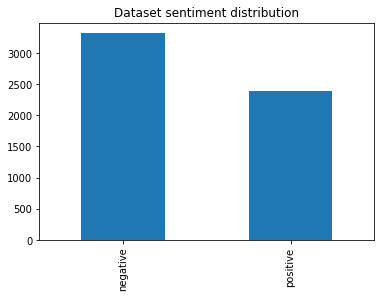

In [5]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

## 3.3 Checkout sentiment distribution

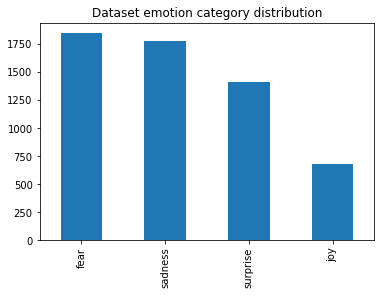

In [6]:
predictions.category.value_counts().plot.bar(title='Dataset emotion category distribution')

# 4.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [7]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.glove_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])
mat.shape

(5703, 100)

## 4.1 Fit and transform T-SNE algorithm


In [8]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (5703, 2)


### Set plotting styles

In [9]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


# 4.2 Plot low dimensional T-SNE GLOVE embeddings with hue for POS


Text(0.5, 1.0, 'T-SNE GLOVE Embeddings, colored by Part of Speech Tag')

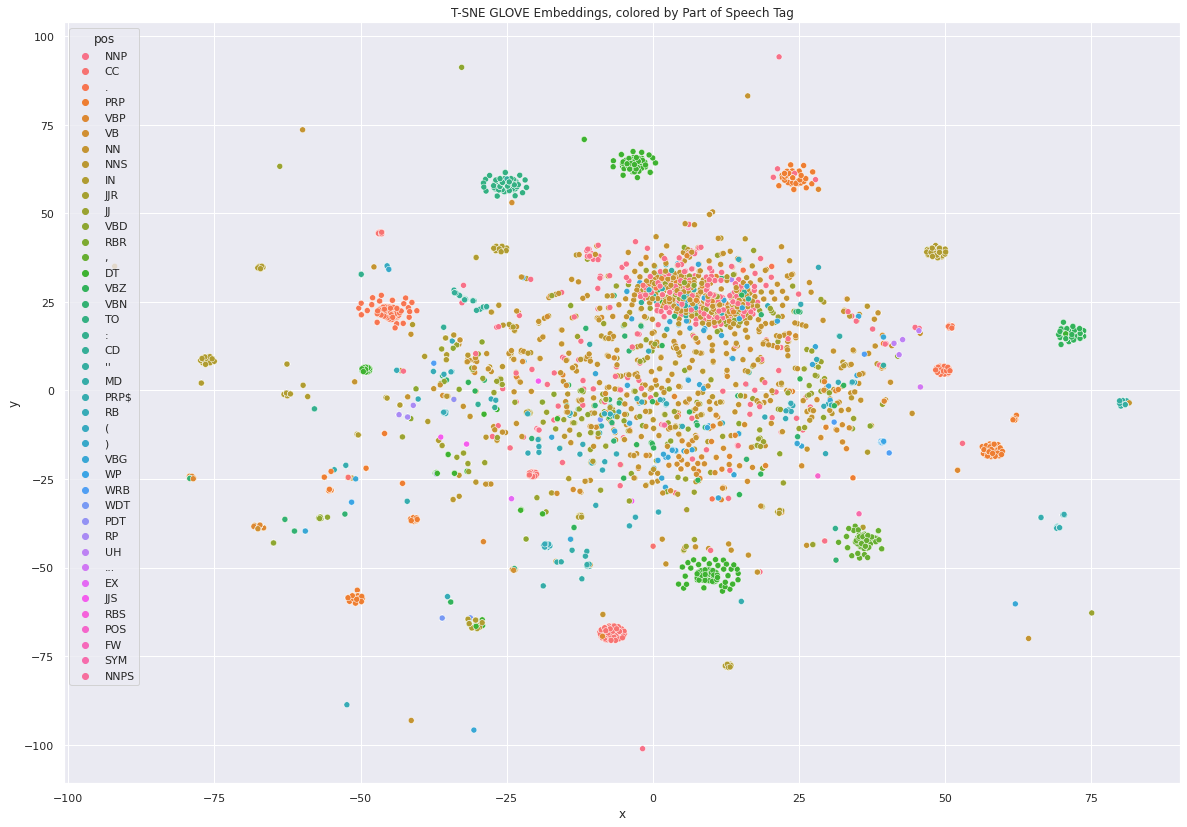

In [10]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.pos)
tsne_df.columns =['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE GLOVE Embeddings, colored by Part of Speech Tag')


##4.3 Plot low dimensional T-SNE GLOVE embeddings with hue for Sarcasm


Text(0.5, 1.0, 'T-SNE GLOVE Embeddings, colored by Sarcasm label')

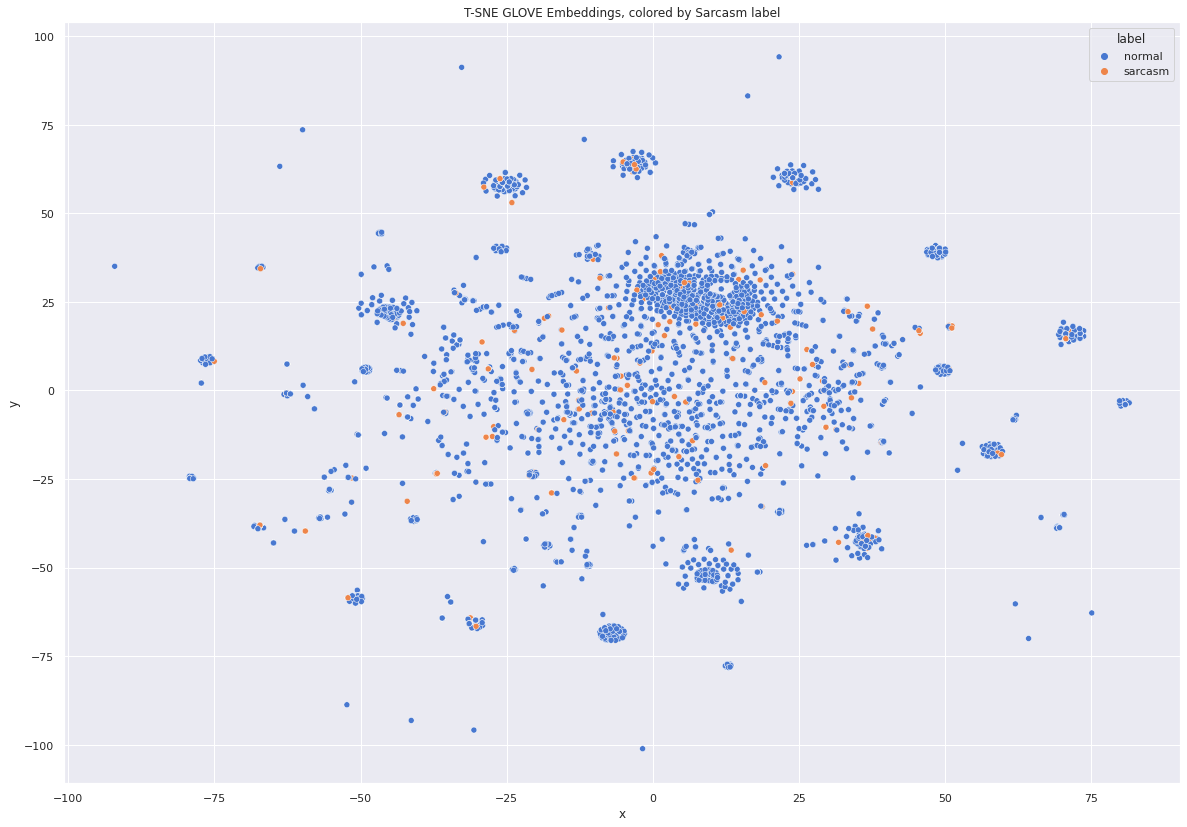

In [11]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
tsne_df.columns =['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE GLOVE Embeddings, colored by Sarcasm label')


## 4.4 Plot low dimensional T-SNE GLOVE embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE GLOVE Embeddings, colored by Sentiment')

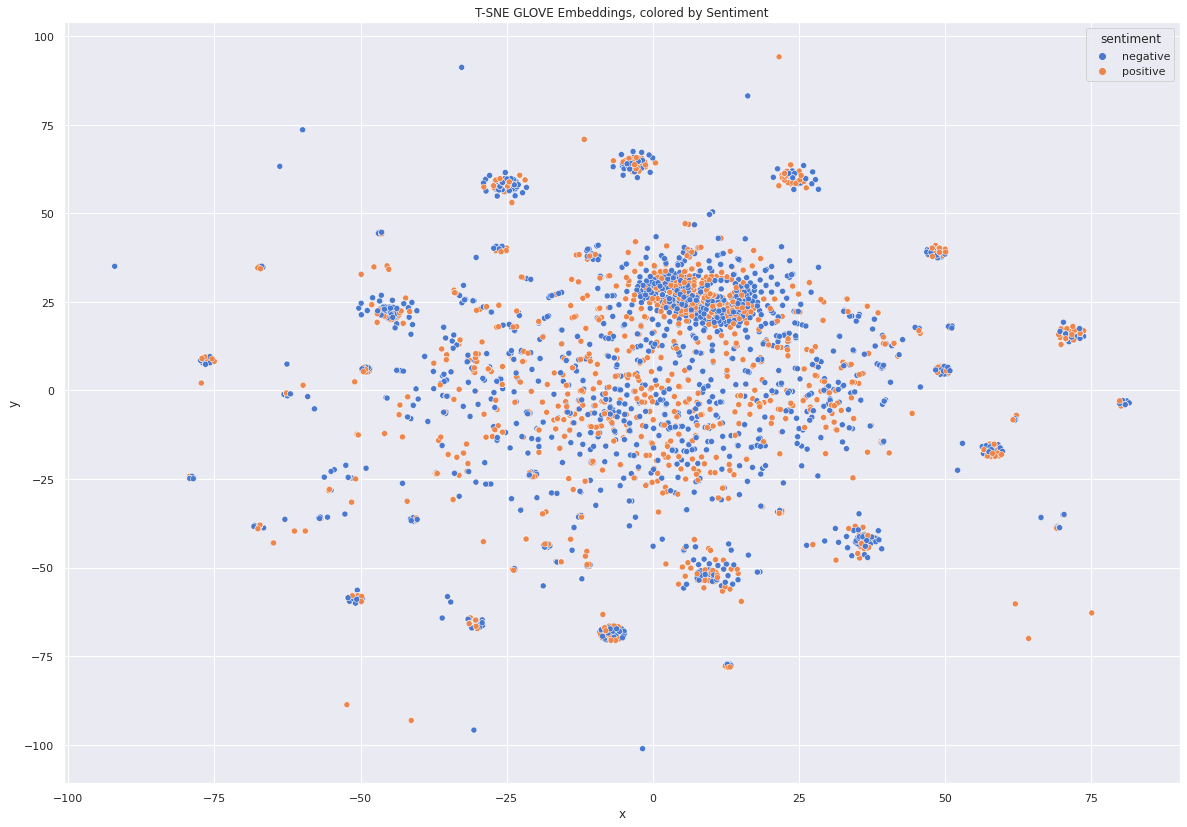

In [12]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
tsne_df.columns =['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE GLOVE Embeddings, colored by Sentiment')


# 4.5 Plot low dimensional T-SNE GLOVE embeddings with hue for Emotions


Text(0.5, 1.0, 'T-SNE GLOVE Embeddings, colored by Emotion')

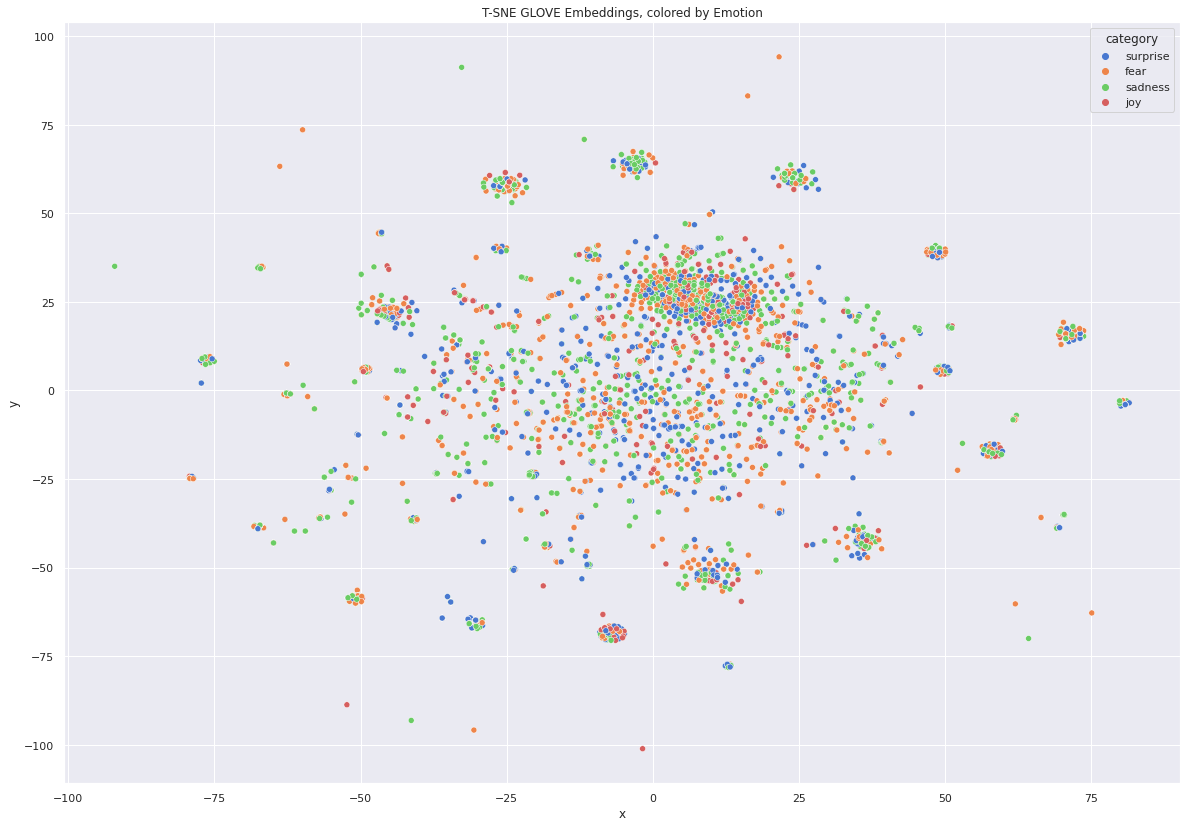

In [13]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.category)
tsne_df.columns =['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE GLOVE Embeddings, colored by Emotion')


Text(0.5, 1.0, 'T-SNE ELMO Embeddings, colored by Emotion')

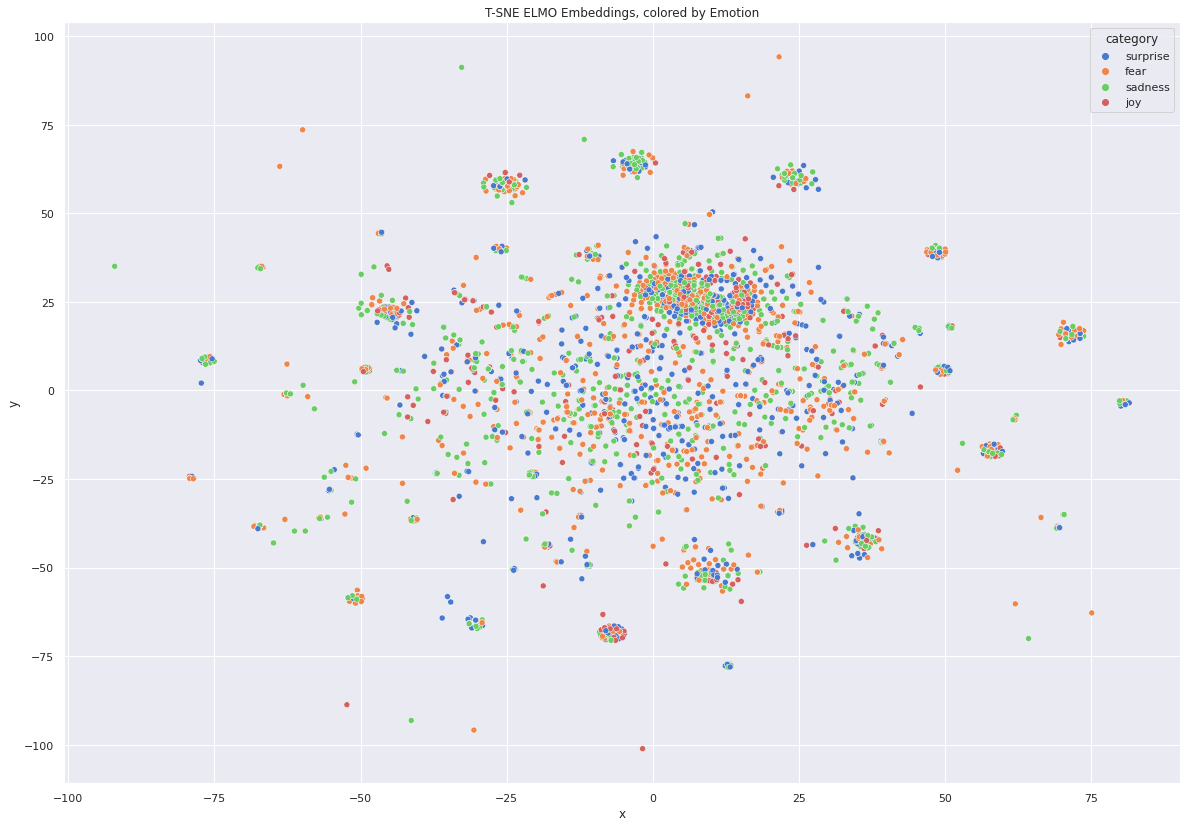

In [14]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.category)
tsne_df.columns =['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE ELMO Embeddings, colored by Emotion')


# 5. NLU has many more GLOVE and otherembedding models!      
Make sure to try them all out!       
You can change 'glove' in nlu.load('glove') to bert, xlnet, albert or any other of the **100+ word embeddings** offerd by NLU

In [15]:
nlu.print_all_model_kinds_for_action('embed')

For language <en> NLU provides the following Models : 
nlu.load('en.embed') returns Spark NLP model glove_100d
nlu.load('en.embed.glove') returns Spark NLP model glove_100d
nlu.load('en.embed.glove.100d') returns Spark NLP model glove_100d
nlu.load('en.embed.bert') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_uncased') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_cased') returns Spark NLP model bert_base_cased
nlu.load('en.embed.bert.large_uncased') returns Spark NLP model bert_large_uncased
nlu.load('en.embed.bert.large_cased') returns Spark NLP model bert_large_cased
nlu.load('en.embed.biobert') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_base_cased') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_large_cased') returns Spark NLP model biobert_pubmed_large_cased
nlu.load('en.embed.biobert.pmc_base_cased') returns Spark NLP model biobert_pmc_base_cased
nlu.lo